## Task 4

In [1]:
import torch
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

import numpy as np
import pandas as pd 
import torch.nn as nn
import torch.nn.functional as F

#Remove all the warnings 
import warnings
warnings.filterwarnings('ignore')

#set Cuda launch blocking = 1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Retina display
%config InlineBackend.figure_format = 'retina'
try: 
    from einops import rearrange 
except:
    %pip install einops --user
    from einops import rearrange 


In [2]:
torch.cuda.set_device(1)

In [3]:
img = torchvision.io.read_image("eyes.jpg")
print(img.shape)

torch.Size([3, 3264, 1836])


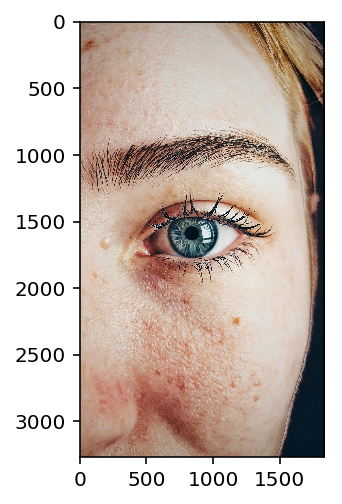

In [4]:
plt.imshow(rearrange(img,'c h w ->h w c'))

In [5]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

scaler_img = MinMaxScaler().fit(img.reshape(-1,1))
scaler_img

MinMaxScaler(copy=True, feature_range=(0, 1))

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1,1)).reshape(img.shape)
print(img_scaled.shape)

img_scaled = torch.tensor(img_scaled)

(3, 3264, 1836)


In [7]:
img_scaled = img_scaled.to(device)
img_scaled 

tensor([[[0.6078, 0.6039, 0.6039,  ..., 0.0627, 0.0745, 0.0863],
         [0.6000, 0.5961, 0.5961,  ..., 0.0078, 0.0196, 0.0314],
         [0.5922, 0.5882, 0.5882,  ..., 0.0275, 0.0353, 0.0392],
         ...,
         [0.5059, 0.5098, 0.5137,  ..., 0.0000, 0.0000, 0.0000],
         [0.4980, 0.5059, 0.5137,  ..., 0.0118, 0.0157, 0.0196],
         [0.4863, 0.4941, 0.5059,  ..., 0.0078, 0.0118, 0.0157]],

        [[0.4706, 0.4667, 0.4667,  ..., 0.1020, 0.1137, 0.1255],
         [0.4627, 0.4588, 0.4588,  ..., 0.0471, 0.0588, 0.0706],
         [0.4549, 0.4510, 0.4510,  ..., 0.0667, 0.0745, 0.0784],
         ...,
         [0.3137, 0.3176, 0.3216,  ..., 0.0784, 0.0824, 0.0863],
         [0.3059, 0.3137, 0.3216,  ..., 0.0980, 0.1020, 0.1059],
         [0.2941, 0.3020, 0.3137,  ..., 0.0941, 0.0980, 0.1020]],

        [[0.3922, 0.3882, 0.3882,  ..., 0.1412, 0.1529, 0.1647],
         [0.3843, 0.3804, 0.3804,  ..., 0.0863, 0.0980, 0.1098],
         [0.3765, 0.3725, 0.3725,  ..., 0.1059, 0.1137, 0.

In [8]:
crop = transforms.functional.crop(img_scaled.cpu(),1250,500,700,700)
crop.shape

torch.Size([3, 700, 700])

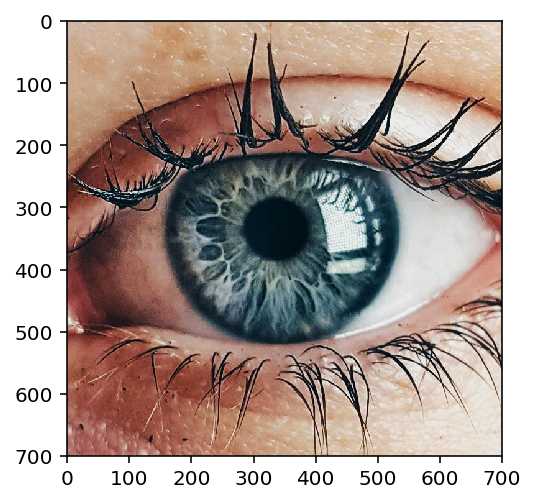

In [9]:
plt.imshow(rearrange(crop,'c h w -> h w c'))

In [10]:
crop = crop.to(device)

In [11]:
channel,height,width = crop.shape
print(channel,height,width)

3 700 700


#### <i>Q.1 Pick an image of your liking and reconstruct it using matrix factorization. Choose a suitable value for the rank r. Run Gradient Descent until it converges, plot the reconstructed image alongside the original image. Calculate and report the RMSE and PSNR metrics.</i>

### <i>Matrix Factorization</i>

In [14]:
def factorize(A,rank=50,itr=1000,device = torch.device("cpu")):

    A = A.to(device)
    channel,height,width = A.shape
    W_s = []
    H_s = []

    mask = ~torch.isnan(A[0])
    for i in range(channel):
        W = torch.randn(height,rank, requires_grad = True, device = device)
        H = torch.randn(rank,width, requires_grad = True, device = device)
        W_s.append(W)
        H_s.append(H)
    
    optimizer = torch.optim.Adam(W_s + H_s, lr = 0.01)
    for i in range(itr):
        losses = []
        for c in range(channel):
            diff_matrix = torch.mm(W_s[c],H_s[c]) - A[c,:,:]
            diff_vector = diff_matrix[mask]
            loss = torch.norm(diff_vector)
            losses.append(loss)

        loss = sum(losses)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if i%1000 == 0:
            print(f"Itr {i}: loss - {loss.item()}")

        if i == itr-1:
            print(f"loss - {loss}")
    del A
    torch.cuda.empty_cache()
    return W_s,H_s

In [13]:
def cat_channels(W,H,channel):
    channels = []

    for c in range(channel):
        temp = torch.mm(W[c],H[c])
        channels.append(temp)
    reconstructed_img = torch.stack(channels,dim=0)
    reconstructed_img = rearrange(reconstructed_img,'c h w -> h w c')

    return reconstructed_img

In [84]:
def calculate_rmse(original_image,reconstructed_img):
    return torch.sqrt(torch.mean(original_image - reconstructed_img)**2)

def calculate_psnr(original_image, reconstructed_img):
    error = (torch.mean(original_image - reconstructed_img)**2)
    i_max = (torch.max(original_image))

    return(20*torch.log10(i_max) - 10*torch.log10(error))

In [102]:
def plot_images(original_img,reconstructed_img, title=""):

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(reconstructed_img.detach().cpu().numpy())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [16]:
rank = 50
W,H = factorize(crop,rank,10000,device)

Itr 0: loss - 14885.889590349674


Itr 1000: loss - 207.505263164309
Itr 2000: loss - 173.45918187595703
Itr 3000: loss - 157.4884307046965
Itr 4000: loss - 148.7526883257675
Itr 5000: loss - 144.42855826899813
Itr 6000: loss - 142.34077549273124
Itr 7000: loss - 141.5403842391076
Itr 8000: loss - 141.10198831480872
Itr 9000: loss - 140.91214357150045
loss - 140.71361751261196


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RMSE: 0.0007536070936765592
PSNR: 62.457100443950964 db


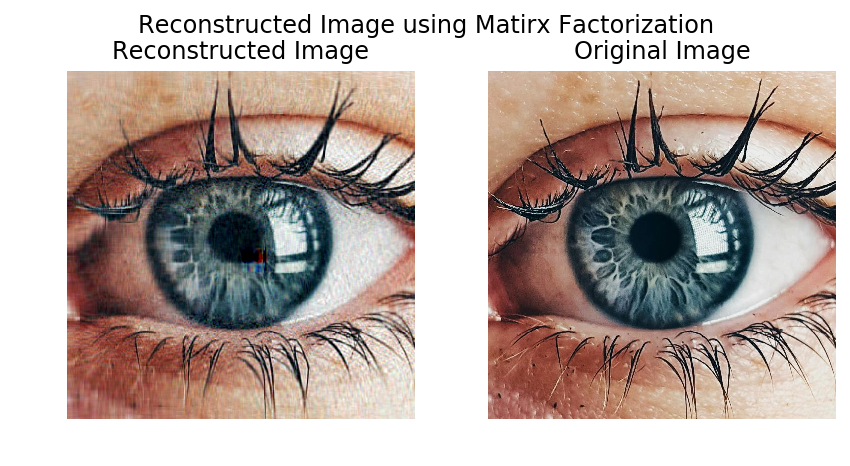

In [103]:
reconstructed_img = cat_channels(W,H,channel)
print(f"RMSE: {calculate_rmse(rearrange(crop,'c h w -> h w c'),reconstructed_img)}")
print(f"PSNR: {calculate_psnr(rearrange(crop,'c h w -> h w c'),reconstructed_img)} db")
plot_images(crop,reconstructed_img,"Reconstructed Image using Matirx Factorization")

In [18]:
del W
del H
torch.cuda.empty_cache()

#### <i>Q.2 Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.</i>

### <i>Matrix Factorization<i>

In [15]:
def patch_image(image,patch_size):
    temp = image.clone()

    channel,height,width = temp.shape
    x = np.random.randint(width-patch_size+1)
    y = np.random.randint(height-patch_size+1)
    # temp[:,y:y+patch_size,x:x+patch_size] = 1
    temp[:,y:y+patch_size,x:x+patch_size] = float('nan')
    
    return temp

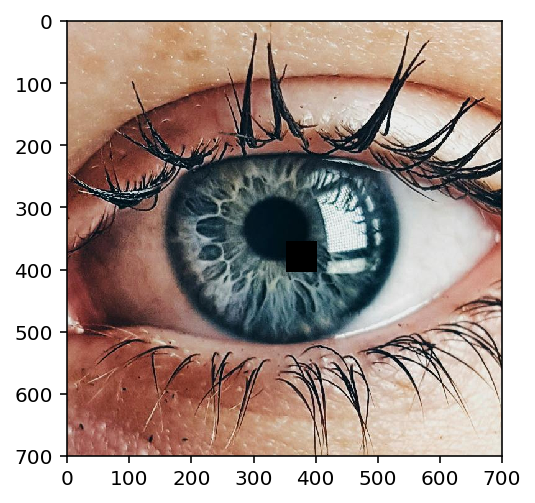

In [17]:
patch_size = 50
patch_img = patch_image(crop,patch_size)
plt.imshow(rearrange(patch_img.cpu(),'c h w -> h w c'))
plt.show()

In [18]:
rank = 50
patch_img = patch_img.to(device)
W,H = factorize(patch_img,rank,10000,device)

Itr 0: loss - 14878.186176899457
Itr 1000: loss - 205.7209450640963
Itr 2000: loss - 172.68351543053112
Itr 3000: loss - 156.33023191791568
Itr 4000: loss - 147.77511661749784
Itr 5000: loss - 143.55708871095106
Itr 6000: loss - 141.7120892450792
Itr 7000: loss - 140.8297065522518
Itr 8000: loss - 140.46724745799474
Itr 9000: loss - 140.24910457859326
loss - 140.068973209465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RMSE: 0.0007536070936765592
PSNR: 62.457100443950964 db


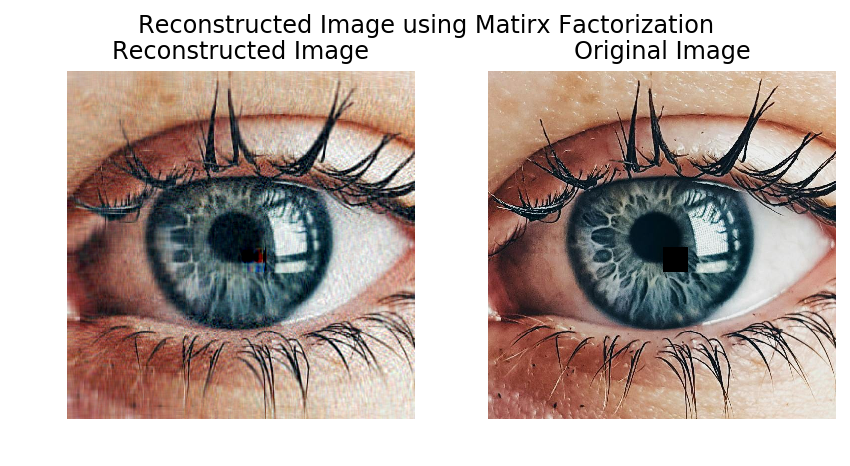

In [104]:
reconstructed_img = cat_channels(W,H,channel)
patch_img_rmse_MF = calculate_rmse(rearrange(crop,'c h w -> h w c'),reconstructed_img)
patch_img_psnr_MF = calculate_psnr(rearrange(crop,'c h w -> h w c'),reconstructed_img)
print(f"RMSE: {patch_img_rmse_MF}")
print(f"PSNR: {patch_img_psnr_MF} db")
plot_images(patch_img,reconstructed_img,"Reconstructed Image using Matirx Factorization")

In [23]:
del W
del H
torch.cuda.empty_cache()

### <i>RFF + Linaer Regression</i>

In [29]:
def coordinate_mapping(img):
    
    c,height,width = img.shape 
    w_coords = torch.arange(width).repeat(height,1)
    h_coords = torch.arange(height).repeat(width,1).T
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords,w_coords],dim=1).float().to(device)

    Y = rearrange(img,'c h w -> (h w) c').float().to(device)
    return X,Y

In [30]:
# Removing 'nan's from the Dataset.
def removve_nans(X,Y,features):
    df_X = pd.DataFrame(X)
    df_Y = pd.DataFrame(Y)
    df = pd.concat((df_X,df_Y), axis = 1)

    df = df.dropna()
    new_X =np.array(df.iloc[:,:features])
    new_Y = np.array(df.iloc[:,features:])
    new_X = torch.tensor(new_X)
    new_Y = torch.tensor(new_Y)
    return new_X,new_Y

In [31]:
X,Y = coordinate_mapping(patch_img)
print(f"X:{X.shape} Y: {Y.shape}")
print("X :",X)

print("Y :",Y)

X:torch.Size([490000, 2]) Y: torch.Size([490000, 3])
X : tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [699., 697.],
        [699., 698.],
        [699., 699.]], device='cuda:1')
Y : tensor([[0.8118, 0.7098, 0.6588],
        [0.8000, 0.6980, 0.6471],
        [0.8039, 0.7020, 0.6510],
        ...,
        [0.9059, 0.8706, 0.8353],
        [0.9098, 0.8745, 0.8392],
        [0.9137, 0.8784, 0.8431]], device='cuda:1')


In [32]:
scaler_X = MinMaxScaler(feature_range=(-1,1)).fit(X.cpu())

scaled_X = scaler_X.transform(X.cpu())

scaled_X = torch.tensor(scaled_X).float().to(device)

In [28]:
new_X,new_Y = removve_nans(scaled_X.cpu().numpy(),Y.cpu().numpy(),2)

In [29]:
print("Dataset size with 'nan' values:")
print(f"X: {scaled_X.shape}\nY: {Y.shape}\n")
print("Datset size after Removing 'nan' values:")
print(f"X: {new_X.shape}\nY: {new_Y.shape}")

Dataset size with 'nan' values:
X: torch.Size([490000, 2])
Y: torch.Size([490000, 3])

Datset size after Removing 'nan' values:
X: torch.Size([487500, 2])
Y: torch.Size([487500, 3])


In [42]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [31]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [33]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 1000 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [33]:
new_X = new_X.to(device)
new_Y = new_Y.to(device)

In [34]:
train(net, 0.01, new_X, new_Y, 5000)

Epoch 0 loss: 0.799609


Epoch 1000 loss: 0.055831
Epoch 2000 loss: 0.055831
Epoch 3000 loss: 0.055831
Epoch 4000 loss: 0.055831


0.05583106726408005

In [34]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):

    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        predict = net(X)
        predict = predict.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    
    rmse = calculate_rmse(rearrange(original_img,'c h w -> h w c'),predict)
    psnr = calculate_psnr(rearrange(original_img,'c h w -> h w c'),predict)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(predict.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    return rmse,psnr

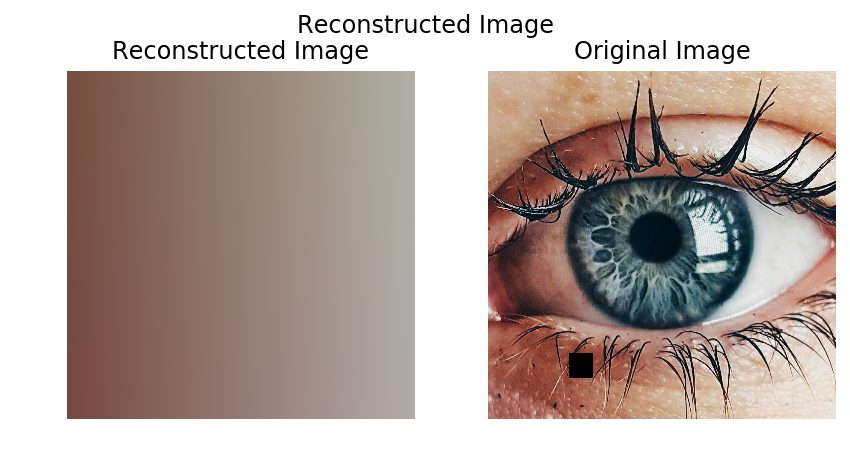

In [36]:
_,_ = plot_reconstructed_and_original_image(patch_img, net, scaled_X, title="Reconstructed Image")

In [37]:
def poly_features(X, degree):
    """
    X: torch.Tensor of shape (num_samples, 2)
    degree: int
    
    return: torch.Tensor of shape (num_samples, degree * (degree + 1) / 2)
    """
    X1 = X[:, 0]
    X2 = X[:, 1]
    X1 = X1.unsqueeze(1)
    X2 = X2.unsqueeze(1)
    X = torch.cat([X1, X2], dim=1)
    poly = PolynomialFeatures(degree=degree)
    X = poly.fit_transform(X.cpu())
    return torch.tensor(X, dtype=torch.float32).to(device)

In [38]:
scaled_X_poly = poly_features(scaled_X, 50)

In [39]:
scaled_X_poly.dtype, scaled_X_poly.shape, Y.shape, Y.dtype

(torch.float32,
 torch.Size([490000, 1326]),
 torch.Size([490000, 3]),
 torch.float32)

In [40]:
features = scaled_X_poly.shape[1]
features 

1326

In [41]:
scaled_new_X_poly,scaled_new_Y_poly = removve_nans(scaled_X_poly.cpu().numpy(),Y.cpu().numpy(),features)

In [42]:
print("Dataset size with 'nan' values:")
print(f"X: {scaled_X_poly.shape}\nY: {Y.shape}\n")
print("Datset size after Removing 'nan' values:")
print(f"X: {scaled_new_X_poly.shape}\nY: {scaled_new_Y_poly.shape}")

Dataset size with 'nan' values:
X: torch.Size([490000, 1326])
Y: torch.Size([490000, 3])

Datset size after Removing 'nan' values:
X: torch.Size([487500, 1326])
Y: torch.Size([487500, 3])


In [43]:
scaled_new_X_poly = scaled_new_X_poly.to(device)
scaled_new_Y_poly = scaled_new_Y_poly.to(device)

In [44]:
net = LinearModel(scaled_new_X_poly.shape[1], 3)
net.to(device)

train(net, 0.005, scaled_new_X_poly, scaled_new_Y_poly, 3000)

Epoch 0 loss: 0.292518
Epoch 1000 loss: 0.036015
Epoch 2000 loss: 0.035220


0.03482350707054138

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


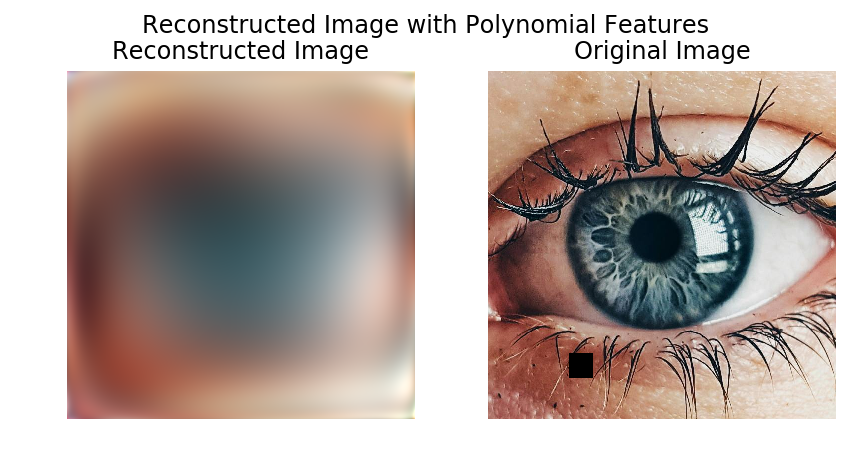

In [45]:
_,_ = plot_reconstructed_and_original_image(patch_img, net, scaled_X_poly, title="Reconstructed Image with Polynomial Features")

In [35]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state= 42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [47]:
del img_scaled
del crop
del X
del new_X
del new_Y
del scaled_X_poly
del scaled_new_X_poly
del scaled_new_Y_poly
torch.cuda.empty_cache()

In [36]:
X_rff = create_rff_features(scaled_X, 12000, 0.008)

In [37]:
X_rff.shape

torch.Size([490000, 12000])

In [38]:
new_X_rff, new_Y_rff = removve_nans(X_rff.cpu().numpy(),Y.cpu().numpy(),X_rff.shape[1])

In [39]:
print("Dataset size with 'nan' values:")
print(f"X: {X_rff.shape}\nY: {Y.shape}\n")
print("Datset size after Removing 'nan' values:")
print(f"X: {X_rff.shape}\nY: {Y.shape}")

Dataset size with 'nan' values:
X: torch.Size([490000, 12000])
Y: torch.Size([490000, 3])

Datset size after Removing 'nan' values:
X: torch.Size([490000, 12000])
Y: torch.Size([490000, 3])


In [40]:
# Swapping the GPU -> CPU memory as RFF features are on GPU device taking muxh space.
# Removing X_rff which is taking nearly 23Gb on GPU Memory
X_rff_on_cpu = X_rff.cpu()
input = X_rff.shape[1]
del X_rff
del Y
del scaled_X
torch.cuda.empty_cache()

new_X_rff = new_X_rff.to(device)
new_Y_rff = new_Y_rff.to(device)

In [44]:
net = LinearModel(input, 3)
net.to(device)

train(net, 0.005, new_X_rff, new_Y_rff, 4000)

Epoch 0 loss: 0.324978
Epoch 1000 loss: 0.016125
Epoch 2000 loss: 0.011268
Epoch 3000 loss: 0.009542


0.008781220763921738

In [45]:
del new_X_rff
del new_Y_rff
torch.cuda.empty_cache()

#get X_rff back on GPU
X_rff = X_rff_on_cpu.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RMSE: 0.0046058980030873956
PSNR: 46.73371367301449 db


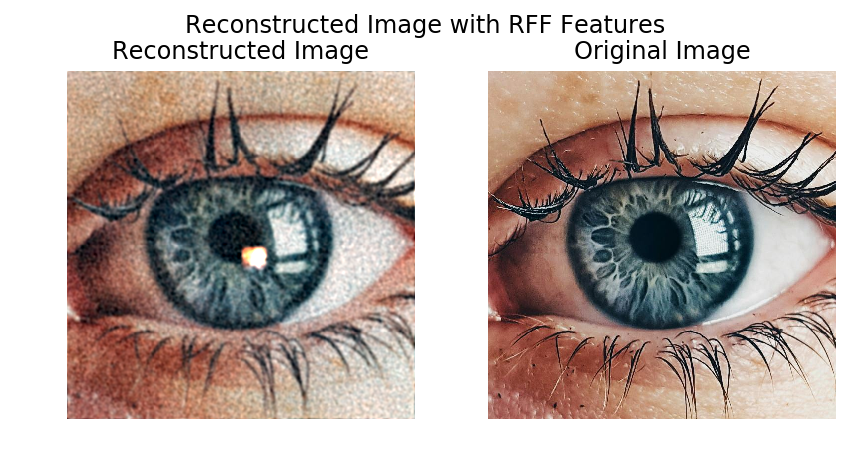

In [86]:
patch_img_rmse_RFF,patch_img_psnr_RFF = plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")
print(f"RMSE: {patch_img_rmse_RFF}")
print(f"PSNR: {patch_img_psnr_RFF} db")
# del X_rff
# torch.cuda.empty_cache()

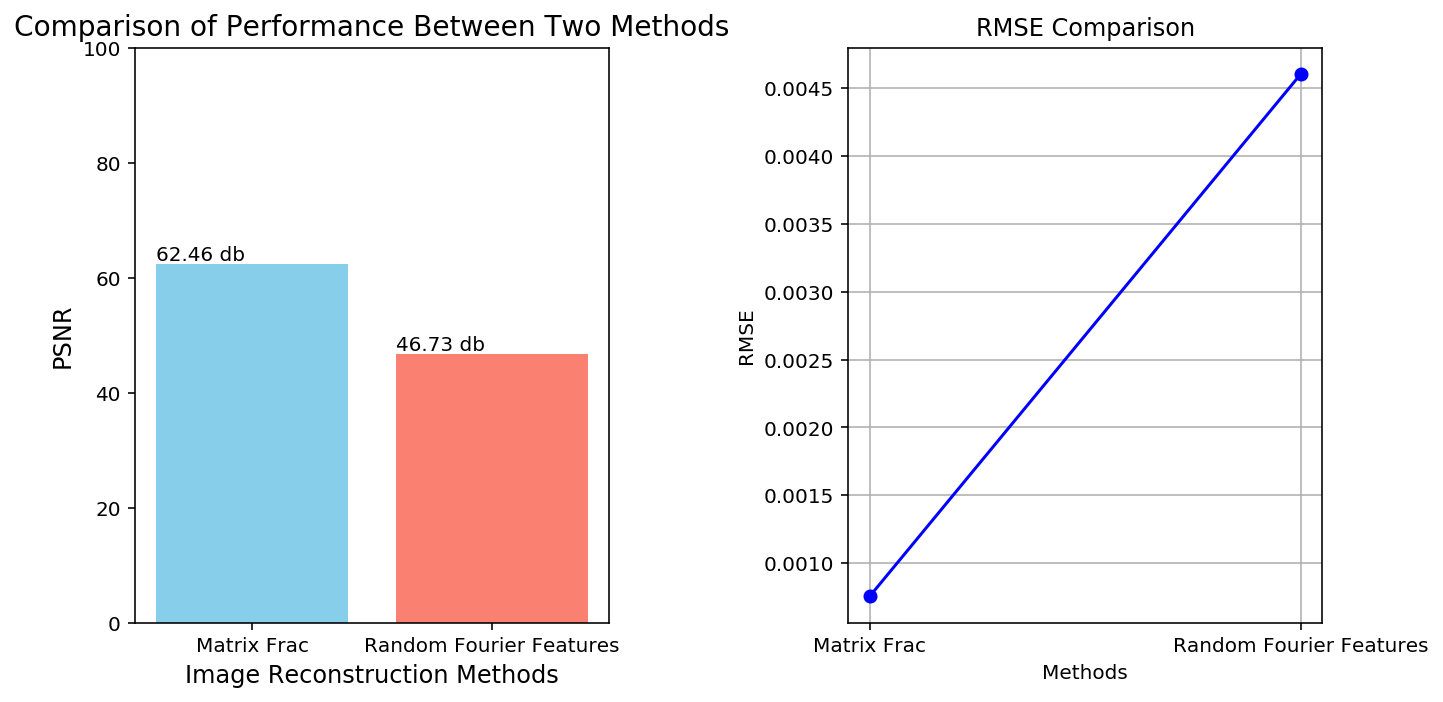

In [101]:
fig1, axs1 = plt.subplots(1, 2, figsize=(10, 5))

# PSNR comparison
methods = ['Matrix Frac', 'Random Fourier Features']
psnr_values = [patch_img_psnr_MF, patch_img_psnr_RFF]


bars = axs1[0].bar(methods, psnr_values, color=['skyblue', 'salmon'])
axs1[0].set_title('Comparison of Performance Between Two Methods', fontsize=14)
axs1[0].set_xlabel('Image Reconstruction Methods', fontsize=12)
axs1[0].set_ylabel('PSNR', fontsize=12)

for bar in bars:
    yval = bar.get_height()
    axs1[0].text(bar.get_x(), yval + .6,f'{"{:,.2f}".format(yval)} db', ha='left', fontsize=10)

axs1[0].set_ylim(0, 100)  

# RMSE comparison
rmse_values = [patch_img_rmse_MF, patch_img_rmse_RFF]

axs1[1].plot(methods, rmse_values, label='RMSE', marker='o', color='b')
axs1[1].set_xlabel('Methods')
axs1[1].set_ylabel('RMSE')
axs1[1].set_title('RMSE Comparison')
axs1[1].grid()

# Show the plot
plt.tight_layout()
plt.show()
